# UK Personal Medical Insurance Cost Predictions through Linear Regression 

> **_Note._** This is completely self-taught, and this is my first machine learning project. Hence, I used AI tools for light assistance (e.g., discovering library functions). All modeling choices, and analysis are my own.

**Author:** Annie Lau with minor AI assistance  
**Date:** September 20, 2025  
**Contact:** annielau08621@gmail.com

## Menu

#### 1. Overview  
#### 2. Dataset Information and Selection
#### 3. Setup
#### 4. Exploratory Data Analysis
#### 5. Model Training
#### 6. Evaluation and Limitations
#### 7. Conclusion and Further Improvements

## 1. Overview 

**Problem:** Many United Kingdom citizens find it hard to budget their individual medical insurance costs.

**Dataset:** Kaggle's "Medical Cost Personal Dataset".

**Goal:** Predict people's individual medical insurance costs based on relevant attributes, such as bmi, age, number of children, through linear regression. Features are relevantly engineered through exploratory data analysis.

**Outcome:** Successfully created medical insurance cost prediction model based on linear regression, that achieved an 85% accuracy rate based on R^2 values. 

## 2. Dataset Information and Selection
### 2.1 Dataset Link
https://www.kaggle.com/datasets/mirichoi0218/insurance
### 2.2 Dataset Summary
This data provides the individual medical insurance costs in United Kingdom. They are billed by health insurance for primary beneficiaries. These are out-of-pocket or claim-based expenses rather than premiums, co-pays, or employer-sponsored group plans. The "charges" represent the total billed amount for healthcare services (e.g., doctor visits, treatments, hospitalizations) that the insurance company processes, influenced by factors like age, health risks (BMI, smoking), and family size.
### 2.3 Dataset Relevancy
This dataset is relevant because it directly tells us UK citizen's personal medical insurance costs. It also has relevant features, such as age, bmi, and number of children.


## 3. Setup

### 3.1 Import All Packages

In [35]:
#import all packages
import numpy as np
import matplotlib.pyplot as plt
import copy
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
%matplotlib inline

### 3.2 Importing All Data

In [36]:
df = pd.read_csv("insurance.csv")
df.head() #reading the first few data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 4. Exploratory Data Analysis

### 4.1 Summary Statistics

In [37]:
#printing summary statistics
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "nulls": df.isna().sum(),
    "unique": df.nunique()
})
summary

,dtype,nulls,unique
age,int64,0,47
sex,object,0,2
bmi,float64,0,548
children,int64,0,6
smoker,object,0,2
region,object,0,4
charges,float64,0,1337


### 4.2 Mean Charges by Age (Error Bar Line Graph)

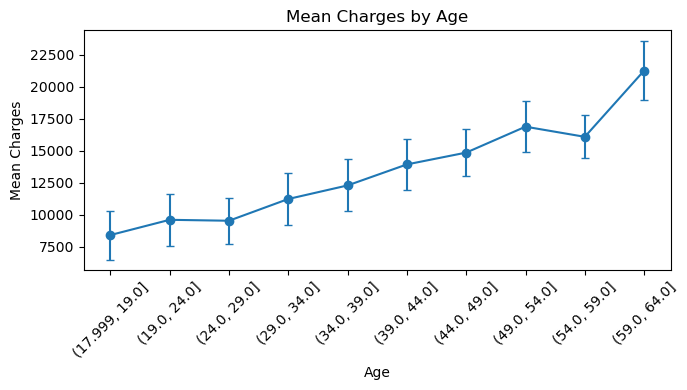

In [38]:
# decile means with 95% confidence interval
def decile_means(frame, col, target="charges", q=10):
    bins = pd.qcut(frame[col], q=q, duplicates="drop")
    g = frame.groupby(bins, observed=True)[target]  # or observed=False
    out = pd.DataFrame({"mean": g.mean(), "n": g.size(), "sem": g.sem()})
    out["ci95"] = 1.96 * out["sem"]
    out["label"] = out.index.astype(str)
    return out.reset_index(drop=True)

# mean charges by age (line graph)
age_stats = decile_means(df, "age")
plt.figure(figsize=(7,4))
plt.errorbar(age_stats["label"], age_stats["mean"], yerr=age_stats["ci95"], fmt="-o", capsize=3)
plt.title("Mean Charges by Age"); plt.xlabel("Age"); plt.ylabel("Mean Charges")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

**Findings:** This shows that there is roughly an upward linear correlation between mean charges and age. Therefore, age would be a feature in the model.

### 4.3 Mean Charges by BMI (Line Graph)

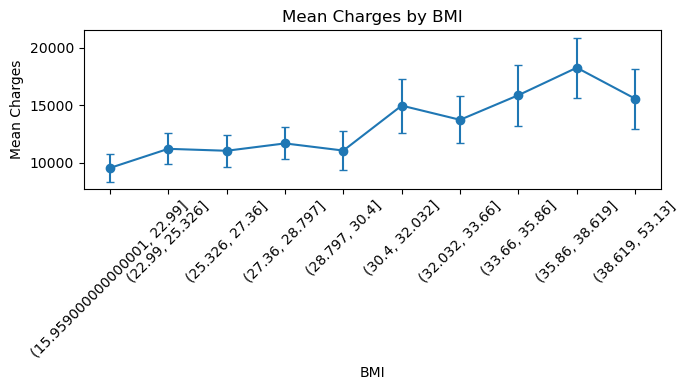

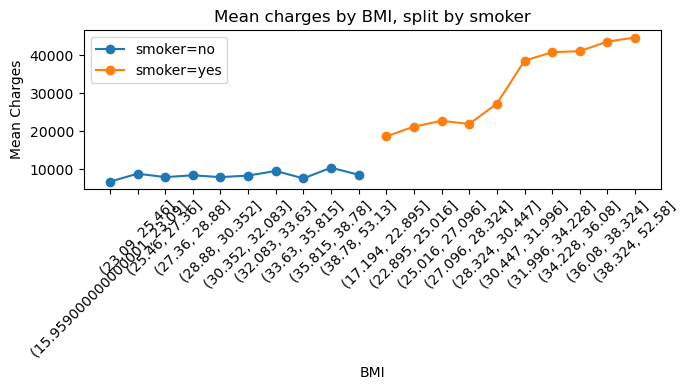

In [39]:
# mean charges by BMI (line graph)
bmi_stats = decile_means(df, "bmi")
plt.figure(figsize=(7,4))
plt.errorbar(bmi_stats["label"], bmi_stats["mean"], yerr=bmi_stats["ci95"], fmt="-o", capsize=3)
plt.title("Mean Charges by BMI"); plt.xlabel("BMI"); plt.ylabel("Mean Charges")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# mean charges by BMI for smokers and non-smokers (line graph)
plt.figure(figsize=(7,4))
for s in ["no","yes"]:
    s_stats = decile_means(df[df["smoker"]==s], "bmi")
    plt.plot(s_stats["label"], s_stats["mean"], "-o", label=f"smoker={s}")
plt.title("Mean charges by BMI, split by smoker"); plt.xlabel("BMI"); plt.ylabel("Mean Charges")
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

**Findings:** There is a slight correlation between bmi and mean charges. The correlation is stronger for smokers. Therefore, bmi, bmi^2 and bmi*smokers (where smokers=1, non-smokers=0) will be features in the model.

### 4.4 Mean Charges by Sex (Bar Chart)

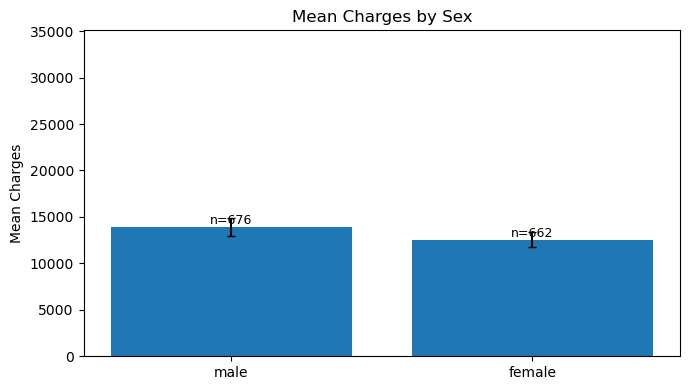

In [40]:
# bar chart creation
def bar_means(frame, cat, target="charges", sort=True):
    g = frame.groupby(cat)[target]
    out = pd.DataFrame({
        cat: g.mean().index,
        "mean": g.mean().values,
        "n": g.size().values,
        "sem": g.sem().fillna(0).values
    })
    out["ci95"] = 1.96 * out["sem"]
    if sort:
        out = out.sort_values("mean", ascending=False).reset_index(drop=True)
    return out

def plot_bar_ci(stats, cat, title, ylim=None):
    plt.figure(figsize=(7,4))
    x = np.arange(len(stats))
    plt.bar(x, stats["mean"], yerr=stats["ci95"], capsize=3)
    plt.xticks(x, stats[cat].astype(str), rotation=0)
    plt.ylabel("Mean Charges")
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    # annotate sample size on top of bars
    for i, (m, n) in enumerate(zip(stats["mean"], stats["n"])):
        plt.text(i, m, f"n={int(n)}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


sex_stats    = bar_means(df, "sex")
smoker_stats = bar_means(df, "smoker")
region_stats = bar_means(df, "region")

ymax = 1.05 * max(
    (sex_stats["mean"] + sex_stats["ci95"]).max(),
    (smoker_stats["mean"] + smoker_stats["ci95"]).max(),
    (region_stats["mean"] + region_stats["ci95"]).max()
)
shared_ylim = (0, ymax)

# mean charges by sex (bar graph)
plot_bar_ci(sex_stats, "sex", "Mean Charges by Sex", ylim=shared_ylim)

**Findings:** This shows that there is a significant difference in mean charges between different sex's mean charges in medical costs. Hence, sex will be a feature in the model, with male=1 and female=0.

### 4.4 Mean Charges by whether the Person is a Smoker (Bar Chart)

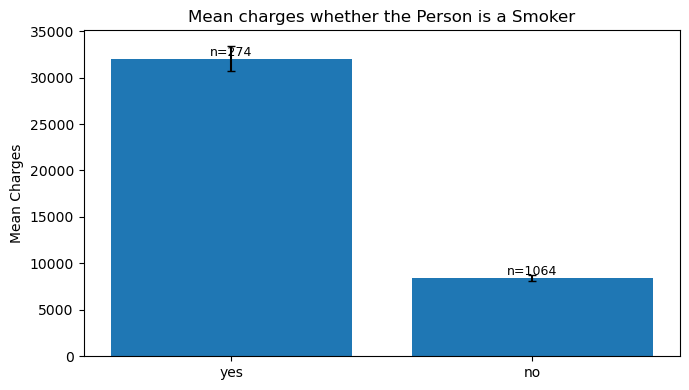

In [41]:
# mean charges by whether the Person is a Smoker 
plot_bar_ci(smoker_stats, "smoker", "Mean charges whether the Person is a Smoker", ylim=shared_ylim)

**Findings:** This shows that there is a significant difference in mean charges between different whether a person smokes and the mean medical cost charges. Hence, whether a person is a smoker or not will be engineered as a feature in the model, with smoker = 1 and non-smoker = 0.

## 5. Model Training

### 5.1 Training Methodology
The model would be trained by randomly selecting 70% of the data, and implementing linear regression. Age, bmi, bmi^2, smoker, sex, and smoker*bmi will be the features engined.

### 5.2 Training Implementation

In [42]:
# Build Features
X = pd.DataFrame({
    "age": df["age"].astype(float),
    "bmi": df["bmi"].astype(float),
    "bmi2": df["bmi"].astype(float) ** 2,
    "smoker": (df["smoker"] == "yes").astype(int),                  # 1 yes, 0 no
    "sex": df["sex"].map({"male": 1, "female": 0}).astype(int),  # 1 male, 2 female
})
X["smoker_bmi"] = X["smoker"] * X["bmi"]
y = df["charges"].astype(float)

# Randomly Select 70% of the data from the dataset
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.70, random_state=42, shuffle=True)
model = LinearRegression().fit(X_tr, y_tr)

# Pull Coeffients
order = ["age","bmi","bmi2","smoker","sex","smoker_bmi"]
b0 = model.intercept_
b  = dict(zip(order, model.coef_[[X.columns.get_loc(c) for c in order]]))

def fmt(v):  # Tider Number Format
    return f"{v:,.4f}"

# 4) Output Equation as Text
equation = (
    f"ŷ (medical costs) = {fmt(b0)}"
    f" + {fmt(b['age'])}·age"
    f" + {fmt(b['bmi'])}·bmi"
    f" + {fmt(b['bmi2'])}·bmi²"
    f" + {fmt(b['smoker'])}·smoker"
    f" + {fmt(b['sex'])}·sex"
    f" + {fmt(b['smoker_bmi'])}·(smoker×bmi)"
    "\n(where smoker ∈ {0 = non-smoker, 1 = smoker}, gender ∈ {1=male, 0=female})"
)
print(equation)

ŷ (medical costs) = -11,154.7659 + 268.3272·age + 597.7797·bmi + -9.2871·bmi² + -20,679.4518·smoker + -350.5300·sex + 1,454.8993·(smoker×bmi)
(where smoker ∈ {0 = non-smoker, 1 = smoker}, gender ∈ {1=male, 0=female})


### 5.3 Medical Cost Model Equation
for smoker ∈ {0 = non-smoker, 1 = smoker}, sex ∈ {1=male, 0=female}  
Medical Costs = -11,154.7659 + 268.3272·Age + 597.7797·BMI + -9.2871·BMI² + -20,679.4518·Smoker + -350.5300·Sex + 1,454.8993·(Smoker×BMI)  

## 6. Evaluation and Limitations


### 6.1 Visualisation of Predicted vs Actual Medical Costs

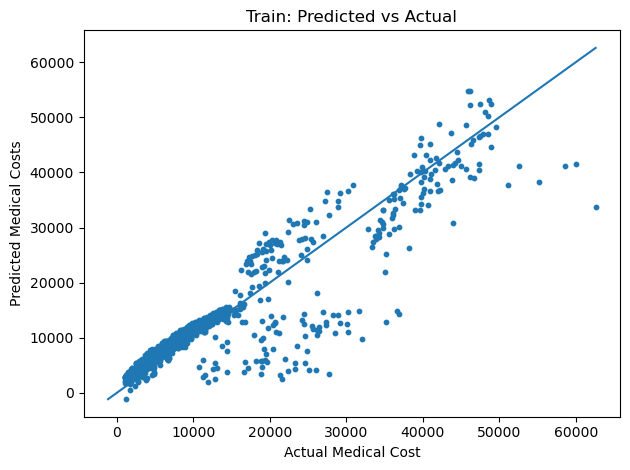

In [43]:
y_tr_pred = model.predict(X_tr)
y_te_pred = model.predict(X_te)

def plot_pred_vs_actual(y_true, y_hat, title):
    plt.figure()
    plt.scatter(y_true, y_hat, s=10)
    # y = x reference line
    min_val = min(np.min(y_true), np.min(y_hat))
    max_val = max(np.max(y_true), np.max(y_hat))
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.xlabel("Actual Medical Cost")
    plt.ylabel("Predicted Medical Costs")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual(y_tr, y_tr_pred, "Train: Predicted vs Actual")

### 6.2 Evaluation Methodology
The 30% of the remaining untrained data is used to test and verify the data. Mean average error, root mean squared error, and R^2 would be computed below.

### 6.3 Evaluation Implementation

In [44]:
pred = model.predict(X_te)
mae   = mean_absolute_error(y_te, pred)
mse   = mean_squared_error(y_te, pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_te, pred)

print(f"Test Results:\nMean Average Error: {mae:.2f}\nRoot Mean Squared Error: {rmse:.2f}\nR²: {r2:.4f}")

Test Results:
Mean Average Error: 2782.91
Root Mean Squared Error: 4562.05
R²: 0.8581


### 6.4 Model Evaluation
This model has a mean average error of £2782.91 and a root mean squared error of £4562.05. It also has an R^2 of 85.81%, which means the model is fairly accurate.  

### 6.5 Model Limitations

Only age, bmi, sex, and whether a person is a smoker is considered in the model. There might be other significant factors, such as living conditions which influences the medical cost. In addition, past data might not be representative of current data. For example, during the Covid-19, the medical costs for older people increased a lot because Covid-19 affects older people more.

## 7.Conclusions and Further Improvements


An R^2 above 80% generally implies that the model is quite accurate. Hence, people in the United Kingdom can use this equation to predict their personal medical insurance costs, and budget better. This solves the budgeting problem for personal medical insurance costs for them. For further model refinements, more relevant data, such as local weather data and more can be collected and added to the features as well.